In [1]:
import sys
sys.path.append("../cmac")

In [12]:
import os 
import numpy as np
import nibabel as nib
import scipy.io as sio
from IPython import display

import loader
import aux_tags
import aux_dicom
import matplotlib.pylab as plt

In [3]:
def get_mesh_2d(mesh_4d, t=0, z_center=8, th=0.5):
    z = mesh_4d[:,2,0]
    x = mesh_4d[:,0,t][np.abs(z-z_center)<th]
    y = mesh_4d[:,1,t][np.abs(z-z_center)<th]
    return x, y

def get_mesh_2d_double(mesh_4d, mesh_4d_2, t=0, z_center=8, th=0.5):
    z = mesh_4d[:,2,0]
    x = mesh_4d[:,0,t][np.abs(z-z_center)<th]
    y = mesh_4d[:,1,t][np.abs(z-z_center)<th]
    x2 = mesh_4d_2[:,0,t][np.abs(z-z_center)<th]
    y2 = mesh_4d_2[:,1,t][np.abs(z-z_center)<th]
    z2 = mesh_4d_2[:,2,t][np.abs(z-z_center)<th]
    return x, y, x2, y2, z2

def contour_to_mask(contour, mask_shape):
    from matplotlib import path
    closed_path = path.Path(contour)

    # Get the points that lie within the closed path
    idx = np.array([[(i,j) for i in range(mask_shape[0])] 
                    for j in range(mask_shape[1])]).reshape(np.prod(mask_shape),2)
    mask = closed_path.contains_points(idx).reshape(mask_shape)
    return mask

#### Download dataset!!

see `./datasets/download_cmac.sh`

In [7]:
subject_id = 7
FID = 0

DATA_DIR = '../datasets/CMAC'

cine_loader   = loader.Cine(subject_id=subject_id, data_dir=DATA_DIR)
tag_loader    = loader.Tag(subject_id=subject_id, data_dir=DATA_DIR)

# load gt mesh and lmks in mm space
tag_loader.load_pts_gt();
cine_loader.load_pts_gt();

# convert lmks from mm to pix space
tag_lmks_pix  = loader.pts_mm_to_pix(tag_loader.lmks_gt_mm,  tag_loader.affine_axial)
cine_lmks_pix = loader.pts_mm_to_pix(cine_loader.lmks_gt_mm, cine_loader.affine_axial)

cine_lmks_mm      = loader.pts_pix_to_mm(cine_lmks_pix, cine_loader.affine)
tag_loader.affine = loader.estimate_affine(ins=tag_lmks_pix[:4], outs=cine_lmks_mm[:4])

In [8]:
# load predicted mesh in mm space and convert to pix space

Tag_mesh_mm   = []
Tag_mesh_pix  = []
Cine_mesh_mm  = []
Cine_mesh_pix = []
Cine_mesh_pix_sax = []

for frame_id in range(25):
    tag_loader.load_pts(frame_id=frame_id)

    tag_mesh_pix  = loader.pts_mm_to_pix(tag_loader.mesh_pred_mm,  tag_loader.affine_axial)
    tag_mesh_mm   = loader.pts_pix_to_mm(tag_mesh_pix, tag_loader.affine) #use if registered to cine
    Tag_mesh_mm  += [tag_mesh_mm]
    Tag_mesh_pix += [tag_mesh_pix]

for frame_id in range(30):
    cine_loader.load_pts(frame_id=frame_id)

    cine_mesh_pix  = loader.pts_mm_to_pix(cine_loader.mesh_pred_mm, cine_loader.affine_axial)
    cine_mesh_mm   = loader.pts_pix_to_mm(cine_mesh_pix, cine_loader.affine)
    Cine_mesh_mm  += [cine_mesh_mm]
    Cine_mesh_pix += [cine_mesh_pix]
    Cine_mesh_pix_sax += [loader.pts_mm_to_pix(cine_mesh_mm, tag_loader.affine)]
    
Tag_mesh_pix  = np.stack(Tag_mesh_pix, -1)
Cine_mesh_pix = np.stack(Cine_mesh_pix, -1)
Tag_mesh_mm   = np.stack(Tag_mesh_mm, -1)
Cine_mesh_mm  = np.stack(Cine_mesh_mm, -1)
Cine_mesh_pix_sax = np.stack(Cine_mesh_pix_sax, -1)


# export to fiducials to load in slicer for visualization
#loader.export_pts_mm_to_slicer_fiducials(Tag_mesh_mm[:,:,0], os.path.join(WORK_DIR, f'v{subject_id}', 'Tag_mesh_mm.fcsv'))

In [9]:
# load cine and tag nifti volumes

tag_nifti_3d_frame1       = tag_loader.load_nifti_3d(frame_id=1, set_affine=tag_loader.affine)
cine_nifti_3d_frame1      = cine_loader.load_nifti_3d(frame_id=0)
cine_nifti_3d_sax_frame1  = aux_dicom.reslice_3d(tag_nifti_3d_frame1, cine_nifti_3d_frame1)

tag_nifti_3d_frame10      = tag_loader.load_nifti_3d(frame_id=10, set_affine=tag_loader.affine)
cine_nifti_3d_frame10     = cine_loader.load_nifti_3d(frame_id=10)
cine_nifti_3d_sax_frame10 = aux_dicom.reslice_3d(tag_nifti_3d_frame10, cine_nifti_3d_frame10)

tag_nifti_3d_frame4      = tag_loader.load_nifti_3d(frame_id=4, set_affine=tag_loader.affine)
cine_nifti_3d_frame4     = cine_loader.load_nifti_3d(frame_id=4)
cine_nifti_3d_sax_frame4 = aux_dicom.reslice_3d(tag_nifti_3d_frame4, cine_nifti_3d_frame4)

In [10]:
# compute predicted error
EPR_mm_0       = (((Tag_mesh_mm[:,:,0]-Cine_mesh_mm[:,:,0])**2).sum(axis=1)**0.5).ravel()
EPR_pix_sax_0  = (((Tag_mesh_pix[:,:,0]-Cine_mesh_pix_sax[:,:,0])**2).sum(axis=1)**0.5).ravel()
EPR_mm_10      = (((Tag_mesh_mm[:,:,10]-Cine_mesh_mm[:,:,10])**2).sum(axis=1)**0.5).ravel()
EPR_pix_sax_10 = (((Tag_mesh_pix[:,:,10]-Cine_mesh_pix_sax[:,:,10])**2).sum(axis=1)**0.5).ravel()

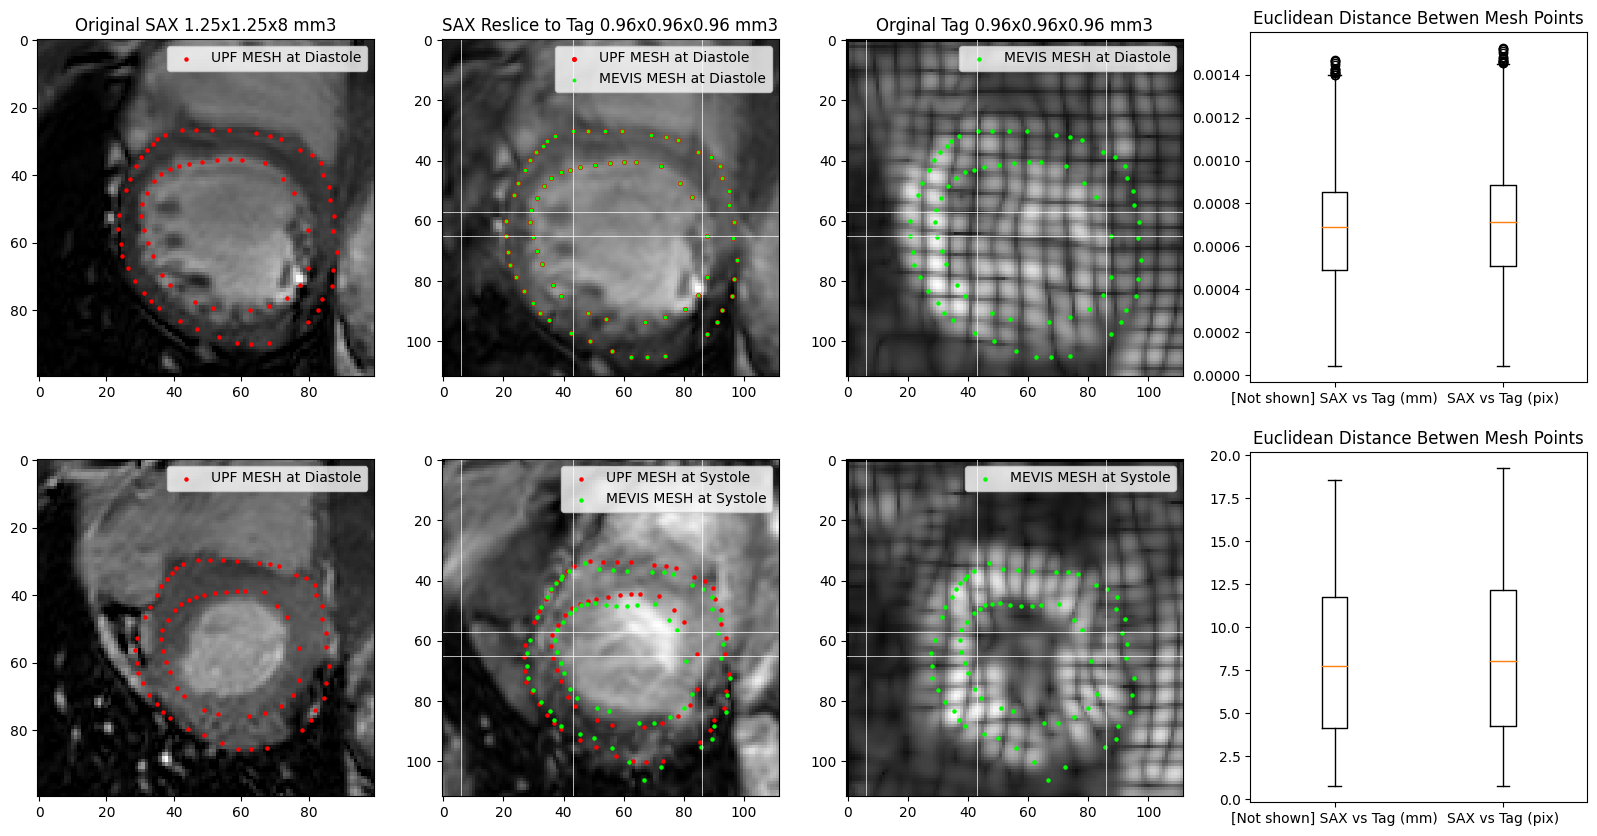

In [11]:
xi,xj= {2:(60,80), 7:(90,100), 16:(50,70)}[subject_id]

zid = 54
x_cine_sax, y_cine_sax, x_cine, y_cine, z_cine = get_mesh_2d_double(Cine_mesh_pix_sax, Cine_mesh_pix, t=0, z_center=zid, th=2)
x_tag, y_tag   = get_mesh_2d(Tag_mesh_pix, t=0, z_center=zid, th=2)

plt.figure(figsize=(20,10))
plt.subplot(241); 
plt.imshow(cine_nifti_3d_frame1.get_fdata()[xi:xi+100,xj:xj+100,int(z_cine.mean())], cmap='gray'); 
plt.scatter(y_cine-xj,x_cine-xi,c='r',s=5, label='UPF MESH at Diastole')
plt.legend()
plt.title('Original SAX 1.25x1.25x8 mm3')
plt.subplot(242); 
plt.imshow(cine_nifti_3d_sax_frame1.get_fdata()[:,:,zid], cmap='gray'); 
plt.axvline(x=43, c='w', linewidth=0.5)
plt.axvline(x=6, c='w', linewidth=0.5)
plt.axvline(x=86, c='w', linewidth=0.5)
plt.axhline(y=65, c='w', linewidth=0.5)
plt.axhline(y=57, c='w', linewidth=0.5)
plt.scatter(y_cine_sax,x_cine_sax,c='r',s=7, label='UPF MESH at Diastole')
plt.scatter(y_tag,x_tag,c='lime',s=3, label='MEVIS MESH at Diastole')
plt.legend()
plt.title('SAX Reslice to Tag 0.96x0.96x0.96 mm3')
plt.subplot(243); 
plt.imshow(tag_nifti_3d_frame1.get_fdata()[:,:,zid], cmap='gray'); 
plt.axvline(x=43, c='w', linewidth=0.5)
plt.axvline(x=6, c='w', linewidth=0.5)
plt.axvline(x=86, c='w', linewidth=0.5)
plt.axhline(y=65, c='w', linewidth=0.5)
plt.axhline(y=57, c='w', linewidth=0.5)
plt.scatter(y_tag,x_tag,c='lime',s=5, label='MEVIS MESH at Diastole')
plt.legend()
plt.title('Orginal Tag 0.96x0.96x0.96 mm3');
plt.subplot(244);
plt.boxplot([EPR_mm_0, EPR_pix_sax_0])
plt.title('Euclidean Distance Betwen Mesh Points')
plt.xticks([1, 2], ['[Not shown] SAX vs Tag (mm)', 'SAX vs Tag (pix)'])

x_cine_sax, y_cine_sax, x_cine, y_cine, z_cine = get_mesh_2d_double(Cine_mesh_pix_sax, Cine_mesh_pix, t=10, z_center=zid, th=2)
x_tag, y_tag   = get_mesh_2d(Tag_mesh_pix, t=10, z_center=zid, th=2)

plt.subplot(245); 
plt.imshow(cine_nifti_3d_frame10.get_fdata()[xi:xi+100,xj:xj+100,int(z_cine.mean())], cmap='gray'); 
plt.scatter(y_cine-xj,x_cine-xi,c='r',s=5, label='UPF MESH at Diastole')
plt.legend()
plt.subplot(246); 
plt.imshow(cine_nifti_3d_sax_frame10.get_fdata()[:,:,zid], cmap='gray'); 
plt.axvline(x=43, c='w', linewidth=0.5)
plt.axvline(x=6, c='w', linewidth=0.5)
plt.axvline(x=86, c='w', linewidth=0.5)
plt.axhline(y=65, c='w', linewidth=0.5)
plt.axhline(y=57, c='w', linewidth=0.5)
plt.scatter(y_cine_sax,x_cine_sax,c='r',s=5, label='UPF MESH at Systole')
plt.scatter(y_tag,x_tag,c='lime',s=5, label='MEVIS MESH at Systole')
plt.legend()
plt.subplot(247); 
plt.imshow(tag_nifti_3d_frame10.get_fdata()[:,:,zid], cmap='gray'); 
plt.axvline(x=43, c='w', linewidth=0.5)
plt.axvline(x=6, c='w', linewidth=0.5)
plt.axvline(x=86, c='w', linewidth=0.5)
plt.axhline(y=65, c='w', linewidth=0.5)
plt.axhline(y=57, c='w', linewidth=0.5)
plt.scatter(y_tag,x_tag,c='lime',s=5, label='MEVIS MESH at Systole')
plt.legend()
plt.subplot(248);
plt.boxplot([EPR_mm_10, EPR_pix_sax_10])
plt.title('Euclidean Distance Betwen Mesh Points')
plt.xticks([1, 2], ['[Not shown] SAX vs Tag (mm)', 'SAX vs Tag (pix)']);

#plt.savefig('results/figures/registraion_v%.2d_1.png'%(subject_id), bbox_inches='tight')